Epoch 0: Loss = 0.04191465303301811
Epoch 1000: Loss = 2.831878065379101e-09
Epoch 2000: Loss = 2.827349021572445e-09
Epoch 3000: Loss = 2.8202931101617423e-09
Epoch 4000: Loss = 2.80608269953575e-09
Epoch 5000: Loss = 2.7820024062208404e-09
Epoch 6000: Loss = 2.7421740433908326e-09
Epoch 7000: Loss = 0.006610150448977947
Epoch 8000: Loss = 2.606606337024475e-12
Epoch 9000: Loss = 2.6072336564014753e-12
Epoch 10000: Loss = 2.6050095240648385e-12
Epoch 11000: Loss = 2.6042204417237036e-12
Epoch 12000: Loss = 2.606085919981682e-12
Epoch 13000: Loss = 2.6059447568588245e-12
Epoch 14000: Loss = 2.603698073117e-12
Epoch 15000: Loss = 3.7196317137500046e-09
Epoch 16000: Loss = 3.664798464697583e-09
Epoch 17000: Loss = 3.5763747519013123e-09
Epoch 18000: Loss = 3.4384377567420188e-09
Epoch 19000: Loss = 2.581514113586536e-09
Epoch 20000: Loss = 2.4527790909445457e-09
Epoch 21000: Loss = 1.6870183028316887e-09
Epoch 22000: Loss = 1.5894877636313254e-09
Epoch 23000: Loss = 1.2728154086261156e-0

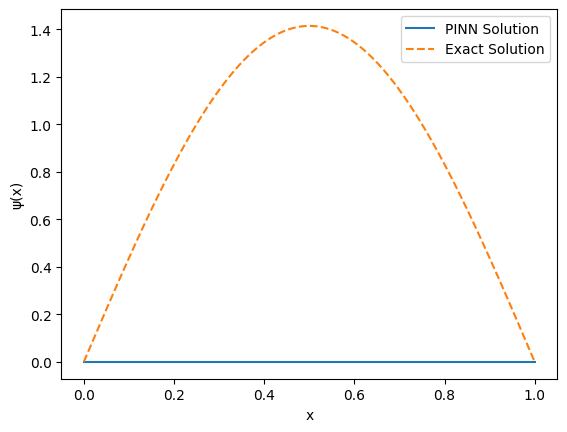

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#Physical constants
hbar = 1.0  # Reduced Planck's constant (in appropriate units)
m = 1.0     # Particle mass
L = 1.0     # Length of the box

# Neural Network Model for PINN
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation='tanh', kernel_initializer='glorot_normal') for layer_size in layers[1:-1]]
        self.output_layer = tf.keras.layers.Dense(layers[-1], kernel_initializer='glorot_normal')

    def call(self, X):
        Z = X
        for layer in self.hidden_layers:
            Z = layer(Z)
        output = self.output_layer(Z)
        return output

# Define the Schrödinger equation
def schrodinger_eq(x, psi, dpsi_dx2, energy):
    return - (hbar**2 / (2 * m)) * dpsi_dx2 - energy * psi

# Loss function for PINN
def loss_fn(model, x, energy):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            psi = model(x)
        dpsi_dx = tape1.gradient(psi, x)
        dpsi_dx2 = tape2.gradient(dpsi_dx, x)
    schrodinger_residual = schrodinger_eq(x, psi, dpsi_dx2, energy)
    return tf.reduce_mean(tf.square(schrodinger_residual))

# Boundary condition loss (ψ(0) = 0, ψ(L) = 0)
def boundary_loss(model, x_boundary):
    psi_boundary = model(x_boundary)
    return tf.reduce_mean(tf.square(psi_boundary))

# Combined loss function
def combined_loss(model, x_interior, x_boundary, energy):
    interior_loss = loss_fn(model, x_interior, energy)
    bc_loss = boundary_loss(model, x_boundary)
    return interior_loss + bc_loss

# Training loop
def train(model, x_train, x_boundary, energy, epochs, lr):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss_value = combined_loss(model, x_train, x_boundary, energy)
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}: Loss = {loss_value.numpy()}')

# Parameters
layers = [1, 2000, 2000, 1]  # Network architecture
x_train = tf.convert_to_tensor(np.linspace(0, L, 100).reshape(-1, 1), dtype=tf.float32)
x_boundary = tf.convert_to_tensor(np.array([[0.0], [L]]), dtype=tf.float32)  # Boundary points (x=0 and x=L)

epochs = 50000  # Number of training iterations
learning_rate = 0.001

# Assume a constant energy value for the first mode (ground state), energy ~ (π^2 hbar^2)/(2mL^2)
energy = (np.pi**2 * hbar**2) / (2 * m * L**2)

# Instantiate and train the model
pinn_model = PINN(layers)
train(pinn_model, x_train, x_boundary, energy, epochs, learning_rate)

# Plot results
x_test = tf.convert_to_tensor(np.linspace(0, L, 100).reshape(-1, 1), dtype=tf.float32)
psi_pred = pinn_model(x_test)

# Exact solution for the ground state (first mode)
psi_exact = np.sqrt(2/L) * np.sin(np.pi * x_test / L)

plt.plot(x_test, psi_pred, label="PINN Solution")
plt.plot(x_test, psi_exact, label="Exact Solution", linestyle="dashed")
plt.xlabel('x')
plt.ylabel('ψ(x)')
plt.legend()
plt.show()
